https://www.youtube.com/watch?v=PCgrgHgy26c&t=128s

In [3]:
  !nvidia-smi

Sun May 28 12:11:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:26:00.0  On |                  N/A |
| 31%   45C    P5    N/A /  75W |    447MiB /  4032MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# First time setup

# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [6]:
# works with colab and not working in jupyter notebook
#!nvcc --version

In [7]:
import torch
torch.__version__

'2.0.1'

In [8]:
#!pip install lightning

In [9]:
import lightning
lightning.__version__

'2.0.2'

## Import libraries
---

In [6]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
#from pytorch_lightning.metrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix


In [11]:
# set prameters for ploting

%matplotlib inline
%config InlineBackend.figure_format='retina'

#sns.set(style='whitegrid',palette='mutted',font_scale=1.2)
#HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF7006D", "#ADFF02", "#8F00FF"]
#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize']=8,5


In [12]:
# set random seed for everytihng 
pl.seed_everything(42)

Global seed set to 42


42

## Load Data

In [13]:
# Load data 

X_train = pd.read_csv("/home/malitjkd/Documents/Codes/AI_ML/Self_Learn/datasets/career_con_2019/X_train.csv")
y_train = pd.read_csv("/home/malitjkd/Documents/Codes/AI_ML/Self_Learn/datasets/career_con_2019/y_train.csv")

In [14]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [15]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


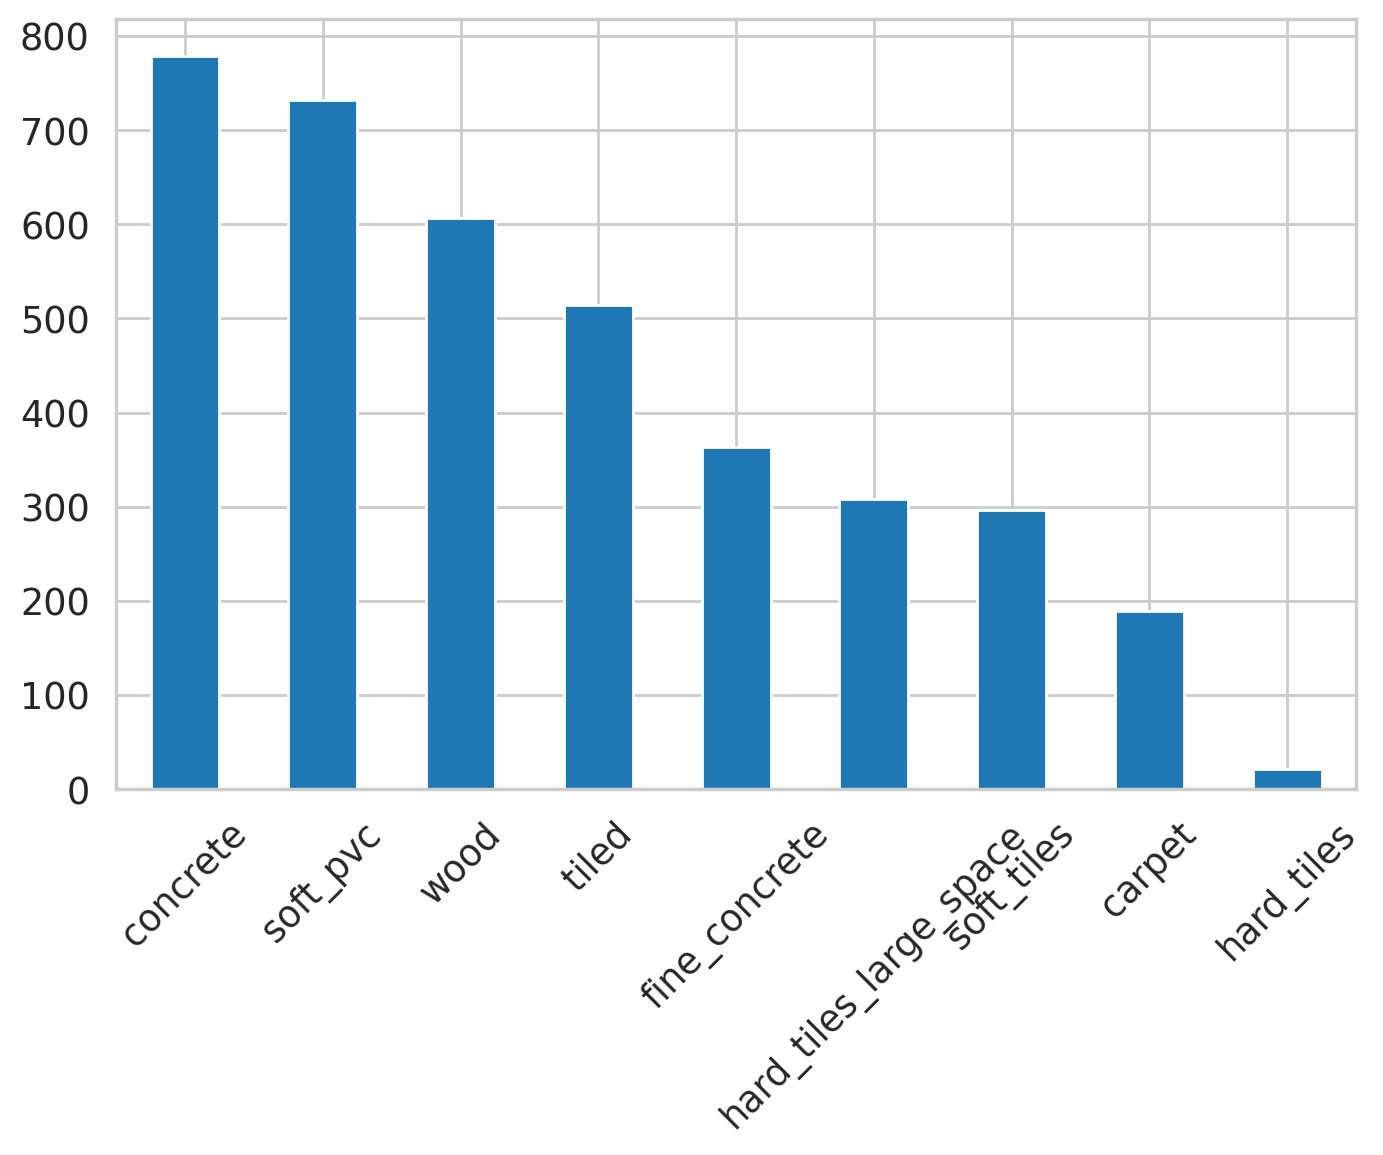

In [16]:
y_train.surface.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

# Preprocessing


In [19]:
# labling the y_lable

label_encoder = LabelEncoder()
encoded_lables = label_encoder.fit_transform(y_train.surface)

# Preint the encoded labes 
encoded_lables[:20]

array([2, 1, 1, 1, 6, 7, 5, 1, 4, 7, 5, 7, 0, 0, 1, 0, 0, 6, 7, 6])

In [20]:
# classes which are encoded in to numbers

label_encoder.classes_

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [21]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [22]:
# Add labes 
y_train["lables"] = encoded_lables

In [23]:
y_train.head()

,series_id,group_id,surface,lables
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6


In [24]:
X_train[:130]

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.10300,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.10600,0.067851,0.029939,0.003386,0.33995,1.50640,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0_125,0,125,-0.75949,-0.63309,-0.104670,-0.10690,-0.083083,-0.044480,0.031726,-0.98193,0.97328,-9.9795
126,0_126,0,126,-0.75950,-0.63307,-0.104640,-0.10693,-0.001305,-0.031012,0.017241,-0.72591,0.34931,-11.9770
127,0_127,0,127,-0.75953,-0.63306,-0.104610,-0.10684,0.073856,0.020353,0.018466,-0.53426,0.80346,-10.6970
128,1_0,1,0,-0.95896,0.24074,0.030758,-0.14661,0.283420,0.002192,-0.050810,2.18480,2.25260,-8.9503


In [25]:
# get list of nessesary feature names in to one array

FEATURE_COLUMNS = X_train.columns.tolist()[3:]
FEATURE_COLUMNS

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

In [32]:
X_train.series_id.value_counts()

0       128
2544    128
2532    128
2533    128
2534    128
       ... 
1274    128
1275    128
1276    128
1277    128
3809    128
Name: series_id, Length: 3810, dtype: int64

In [34]:
# Cheack all series have same rows of occranaces 
(X_train.series_id.value_counts() == 128).sum()

3810

In [35]:
len(y_train)

3810

In [36]:
sequences = []

for series_id, group in X_train.groupby("series_id"):
  sequence_features = group[FEATURE_COLUMNS]
  label = y_train[y_train.series_id == series_id].iloc[0].lables
  
  sequences.append((sequence_features,label))

In [38]:
sequences[4]

(     orientation_X  orientation_Y  orientation_Z  orientation_W  \
 512       -0.88673        0.43740       0.061771       -0.13630   
 513       -0.88681        0.43726       0.061695       -0.13626   
 514       -0.88689        0.43713       0.061632       -0.13615   
 515       -0.88695        0.43703       0.061579       -0.13611   
 516       -0.88701        0.43693       0.061517       -0.13608   
 ..             ...            ...            ...            ...   
 635       -0.89650        0.41723       0.058506       -0.13706   
 636       -0.89660        0.41704       0.058448       -0.13699   
 637       -0.89670        0.41686       0.058371       -0.13693   
 638       -0.89680        0.41663       0.058327       -0.13696   
 639       -0.89689        0.41646       0.058247       -0.13695   
 
      angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
 512            0.025631            0.048867           -0.122520   
 513            0.062175            0.055693  

In [39]:
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2)

In [40]:
len(train_sequences), len(test_sequences)

(3048, 762)

## Dataset

In [45]:
encoded_lables.size

3810

In [46]:
for x in encoded_lables:
    print(x)

2
1
1
1
6
7
5
1
4
7
5
7
0
0
1
0
0
6
7
6
7
4
6
7
6
6
2
3
7
4
6
6
2
1
1
1
7
0
5
8
2
8
2
8
6
3
5
2
1
5
1
6
6
1
0
6
2
2
0
6
1
7
5
4
5
1
7
7
1
5
1
1
5
5
8
2
6
2
5
2
6
7
5
8
2
6
1
5
6
8
5
5
2
2
1
6
8
8
4
7
2
6
8
5
2
5
6
6
5
5
8
2
5
1
6
5
5
6
0
4
7
6
5
5
4
1
7
7
0
6
5
5
2
5
6
6
6
6
8
1
6
7
4
5
1
6
7
8
3
0
6
1
1
4
5
2
6
1
5
6
7
2
1
5
8
4
5
2
2
2
7
7
8
1
7
4
0
8
5
4
6
7
1
4
5
4
5
7
0
3
2
6
8
5
2
1
6
8
1
1
7
5
1
5
8
5
0
8
1
4
6
5
1
0
5
8
8
8
6
0
7
6
5
5
4
7
8
5
5
8
1
2
5
1
7
1
6
5
2
7
6
5
1
1
0
6
5
5
6
5
0
8
5
6
7
8
8
3
6
6
5
1
5
8
5
8
5
5
1
5
8
7
6
4
2
6
7
1
6
5
2
1
5
5
7
4
5
5
5
5
5
6
6
6
5
5
4
8
6
1
4
5
5
7
1
7
1
6
0
7
1
4
0
7
6
1
6
7
0
1
5
6
8
1
7
5
5
5
8
5
1
5
8
1
6
1
8
5
7
6
5
8
1
4
8
1
5
7
6
1
4
6
2
1
5
8
1
6
2
8
1
5
1
5
5
6
7
5
7
8
6
6
6
1
5
6
4
6
7
6
6
5
7
5
4
6
7
1
5
0
5
8
0
2
2
0
1
6
4
6
1
1
5
1
1
6
6
5
1
5
7
7
5
5
1
2
5
8
8
1
5
6
7
5
5
6
4
1
1
7
5
7
4
5
5
5
8
5
1
6
6
2
8
4
5
6
8
8
6
1
7
5
6
5
6
6
5
4
6
3
6
8
4
6
5
5
1
5
6
1
1
1
5
8
6
2
7
5
6
1
6
7
5
8
7
6
2
1
7
2
5
5
1
2
1
1
7
6
1
0
